# Imports

In [1]:
#data import
import wget
import urllib

# regex
import re

#time
import pytz as tz
from datetime import datetime

#data explore
import numpy as np
np.random.seed(1337)

#support for reading excel files
import xlrd

# dataframes in python
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

In [3]:
import os
os.chdir('/home/tapas/data/')
os.listdir(".")

['fill.csv']

In [4]:
df = pd.read_csv('fill.csv')

# Visualization: Confusion matrices and AUC curves

In [5]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

In [6]:
train = df

In [7]:
X = train.drop(labels = ["Target"],axis = 1)
y = train["Target"]

#### Feature Selection

In [8]:
import warnings
from sklearn.feature_selection import SelectKBest, f_classif

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif, 25)
selector.fit(X, y)

SelectKBest(k=25, score_func=<function f_classif at 0x7fb5e937d598>)

In [9]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-25:][::-1]
selector.scores_[top_indices]
X.columns[top_indices]

Index(['PROMPLEDG', 'Market.Capitalisation', 'Beta', 'OTHERS', 'EPS', 'FORGN',
       'PVT', 'P.B', 'NAT', 'PBPTCE', 'BVS', 'TA', 'PATCE', 'ROCE', 'PBPTEQ',
       'RONW', 'Alpha', 'PBPTTA', 'PATTA', 'OPRFINCOS', 'ROTA', 'TURNOVER',
       'ROE', 'CASHROE', 'CR'],
      dtype='object')

### Feature scaling

In [10]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42)

### Models

#### Logistic regression (baseline models)

In [13]:
from sklearn import linear_model

# Create logistic regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

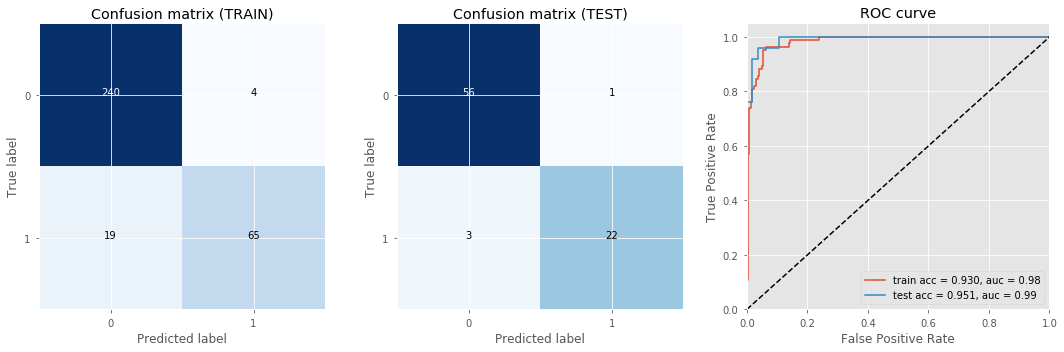

In [14]:
y_train_pred = regr.predict_proba(X_train)[:,1]
y_test_pred = regr.predict_proba(X_test)[:,1]

threshold = 0.5

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

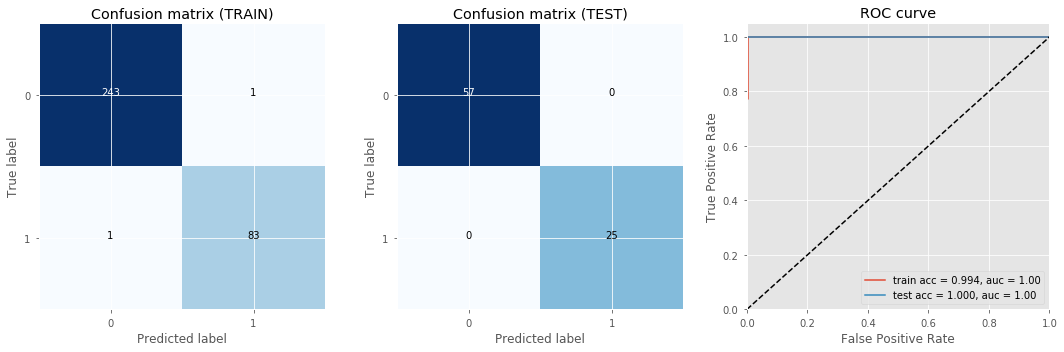

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

#threshold = 0.07
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

#### Decision Trees boosting

An iterative model for refining a model by looking at the remainder error.

In [17]:
import xgboost as xgb

/home/tapas/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
num_round = 5
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[0]	eval-error:0.02439	eval-logloss:0.464286	train-error:0.02439	train-logloss:0.461905
[1]	eval-error:0.012195	eval-logloss:0.332352	train-error:0.015244	train-logloss:0.329684
[2]	eval-error:0.012195	eval-logloss:0.252239	train-error:0.009146	train-logloss:0.242215
[3]	eval-error:0.012195	eval-logloss:0.194002	train-error:0.006098	train-logloss:0.184291
[4]	eval-error:0.012195	eval-logloss:0.152271	train-error:0.006098	train-logloss:0.143059


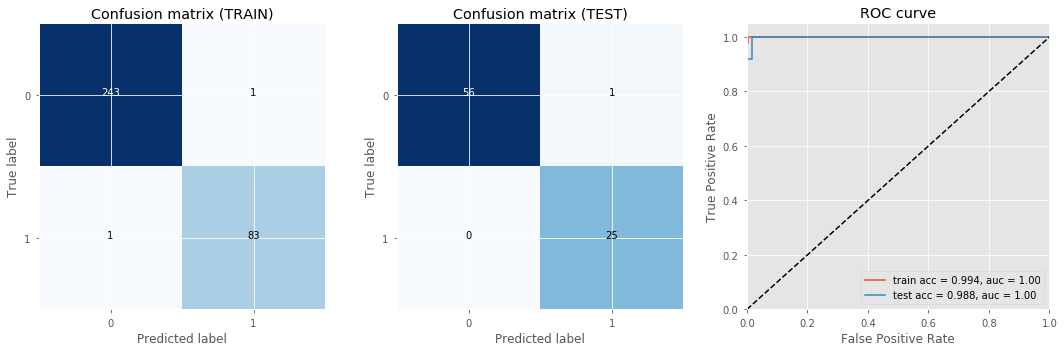

In [20]:
threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

#### Feed forward deep neural nets

In [21]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

Using TensorFlow backend.


In [22]:
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(256, input_shape=(input_dim,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1,  activation='sigmoid'))

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
from keras.callbacks import Callback

class BatchLogger(Callback):
    def on_train_begin(self, epoch, logs={}):
        self.log_values = {}
        for k in self.params['metrics']:
            self.log_values[k] = []

    def on_epoch_end(self, batch, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values[k].append(logs[k])
    
    def get_values(self, metric_name, window):
        d =  pd.Series(self.log_values[metric_name])
        return d.rolling(window,center=False).mean()

bl = BatchLogger()

In [25]:
history = model.fit(
              np.array(X_train), np.array(y_train),
              batch_size=25, epochs=5, verbose=1, callbacks=[bl],
              validation_data=(np.array(X_test), np.array(y_test)))

Train on 328 samples, validate on 82 samples
Epoch 1/5
328/328 [==============================] - 0s - loss: 0.6000 - acc: 0.7439 - val_loss: 0.5915 - val_acc: 0.6951
Epoch 2/5
328/328 [==============================] - 0s - loss: 0.5201 - acc: 0.7439 - val_loss: 0.4938 - val_acc: 0.6951
Epoch 3/5
328/328 [==============================] - 0s - loss: 0.4441 - acc: 0.7439 - val_loss: 0.4341 - val_acc: 0.6951
Epoch 4/5
328/328 [==============================] - 0s - loss: 0.3928 - acc: 0.7835 - val_loss: 0.3747 - val_acc: 0.9146
Epoch 5/5
328/328 [==============================] - 0s - loss: 0.3562 - acc: 0.9238 - val_loss: 0.3363 - val_acc: 0.9390


In [26]:
score = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print('Test log loss:', score[0])
print('Test accuracy:', score[1])

Test log loss: 0.336272838639
Test accuracy: 0.939024384429


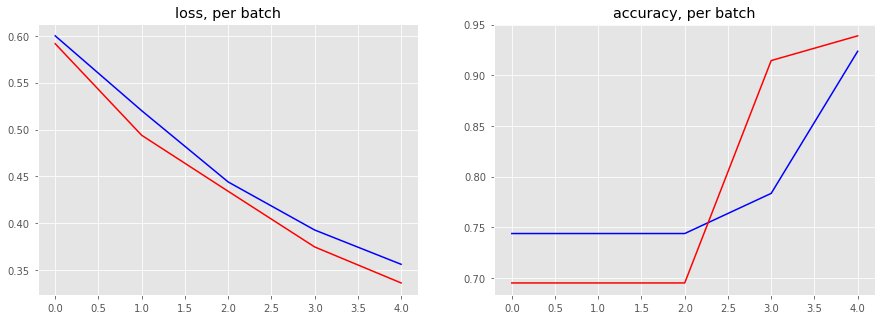

In [27]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title('loss, per batch')
plt.plot(bl.get_values('loss',1), 'b-', label='train');
plt.plot(bl.get_values('val_loss',1), 'r-', label='test');

plt.subplot(1, 2, 2)
plt.title('accuracy, per batch')
plt.plot(bl.get_values('acc',1), 'b-', label='train');
plt.plot(bl.get_values('val_acc',1), 'r-', label='test');
plt.show()

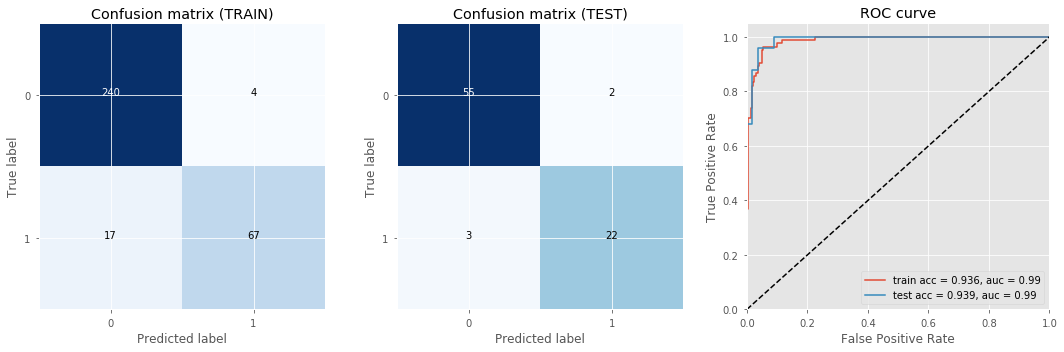

In [28]:
y_train_pred = model.predict_on_batch(np.array(X_train))[:,0]
y_test_pred = model.predict_on_batch(np.array(X_test))[:,0]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0], y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)')
plot_cm(ax[1], y_test, y_test_pred, [0,1], 'Confusion matrix (TEST)')

plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred)
    
plt.tight_layout()
plt.show()

#### Peeking in the "brain" of our neural network

In [29]:
# we build a new model with the activations of the old model
# this model is truncated before the last layer

model2 = Sequential()
model2.add(Dense(256, input_shape=(input_dim,), activation='relu', weights=model.layers[0].get_weights()))
model2.add(Dense(256, activation='relu', weights=model.layers[1].get_weights()))
model2.add(Dense(64, activation='relu', weights=model.layers[2].get_weights()))
model2.add(Dense(64, activation='relu', weights=model.layers[3].get_weights()))
model2.add(Dense(10, activation='sigmoid', weights=model.layers[4].get_weights()))

In [30]:
activations = model2.predict_on_batch(np.array(X_test))

##### "Picking the brain" (method 1):  TSNE analysis

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=25, verbose=0, n_iter=500, random_state=1337)
samples = tsne.fit_transform(activations)

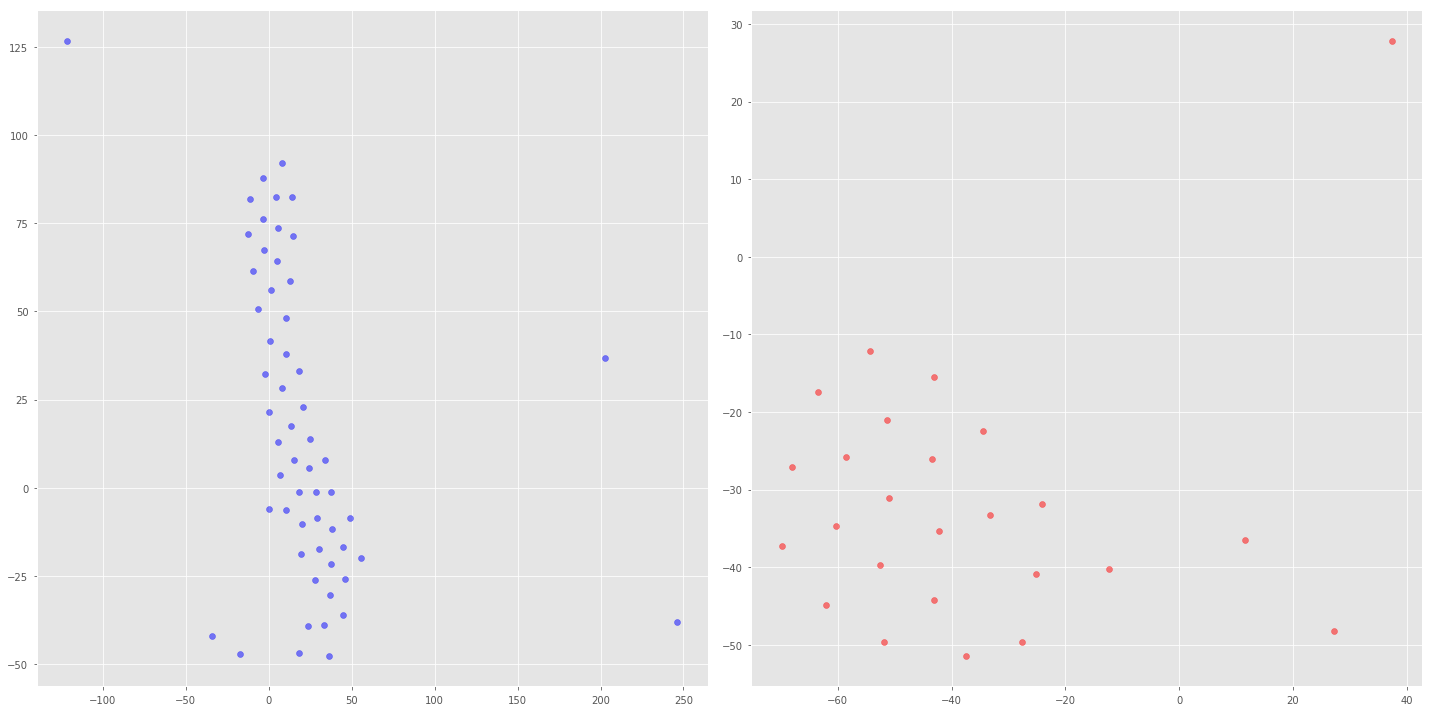

In [32]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].scatter(*samples[y_test==0].T,color='b', alpha=0.5, label='default: NO')
ax[1].scatter(*samples[y_test==1].T,color='r', alpha=0.5, label='default: YES')

plt.tight_layout()
plt.show()

In [34]:
# cluster and show the lift curve for that particular segment
# percent of defaulting in that specific cluster
# histogram of the the top caracterizing functions with that

In [35]:
from pyclustering.cluster.optics import optics

# Create OPTICS algorithm for cluster analysis
optics_instance = optics(samples, 1, 3, 100);

# Run cluster analysis
optics_instance.process();
 
# Obtain results of clustering
clusters = optics_instance.get_clusters();
noise = optics_instance.get_noise();

# Obtain rechability-distances
ordering = optics_instance.get_ordering();

# Visualization of cluster ordering in line with reachability distance.
indexes = [i for i in range(0, len(ordering))];

fig = plt.figure()
fig.set_size_inches(20,5)
plt.bar(indexes, ordering);
plt.show(); 

ValueError: max() arg is an empty sequence

In [36]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

pred  = (y_test_pred>0.5).astype(int)
truth = (y_test>0.5).values.astype(int)

avg = y_test.mean()

cluster_defaulting_data = [ 
    [ 
        len(cl) , 
        truth[cl].mean(), 
        pred[cl].mean(),
        max(np.bincount(truth[cl])/len(truth[cl])),
        max(np.bincount(pred[cl])/len(pred[cl])),
        truth[cl].mean()/avg,
        pred[cl].mean()/avg,
        accuracy_score(truth[cl], pred[cl]),
        f1_score(truth[cl], pred[cl]),
        precision_score(truth[cl], pred[cl]),
        recall_score(truth[cl], pred[cl])
    ] for cl in clusters ]

columns=[
    'count', 
    'rate_truth', 
    'rate_pred', 
    'purity_truth', 
    'purity_pred', 
    'lift_truth', 
    'lift_pred', 
    'accuracy', 
    'f1', 
    'precision', 
    'recall']

cl_df = pd.DataFrame(cluster_defaulting_data, columns=columns)

NameError: name 'clusters' is not defined

In [45]:
# check which have the best F1 score
sel = ((cl_df['f1']>0.7) | (cl_df['accuracy']>0.82))
clusters_topsel = cl_df[sel]
clusters_topsel.head(10)

,count,rate_truth,rate_pred,purity_truth,purity_pred,lift_truth,lift_pred,accuracy,f1,precision,recall
0,57,0.035088,0.00,0.964912,1.00,0.115088,0.0000,0.964912,0.00000,0.000000,0.000000
1,25,0.920000,0.96,0.920000,0.96,3.017600,3.1488,0.880000,0.93617,0.916667,0.956522


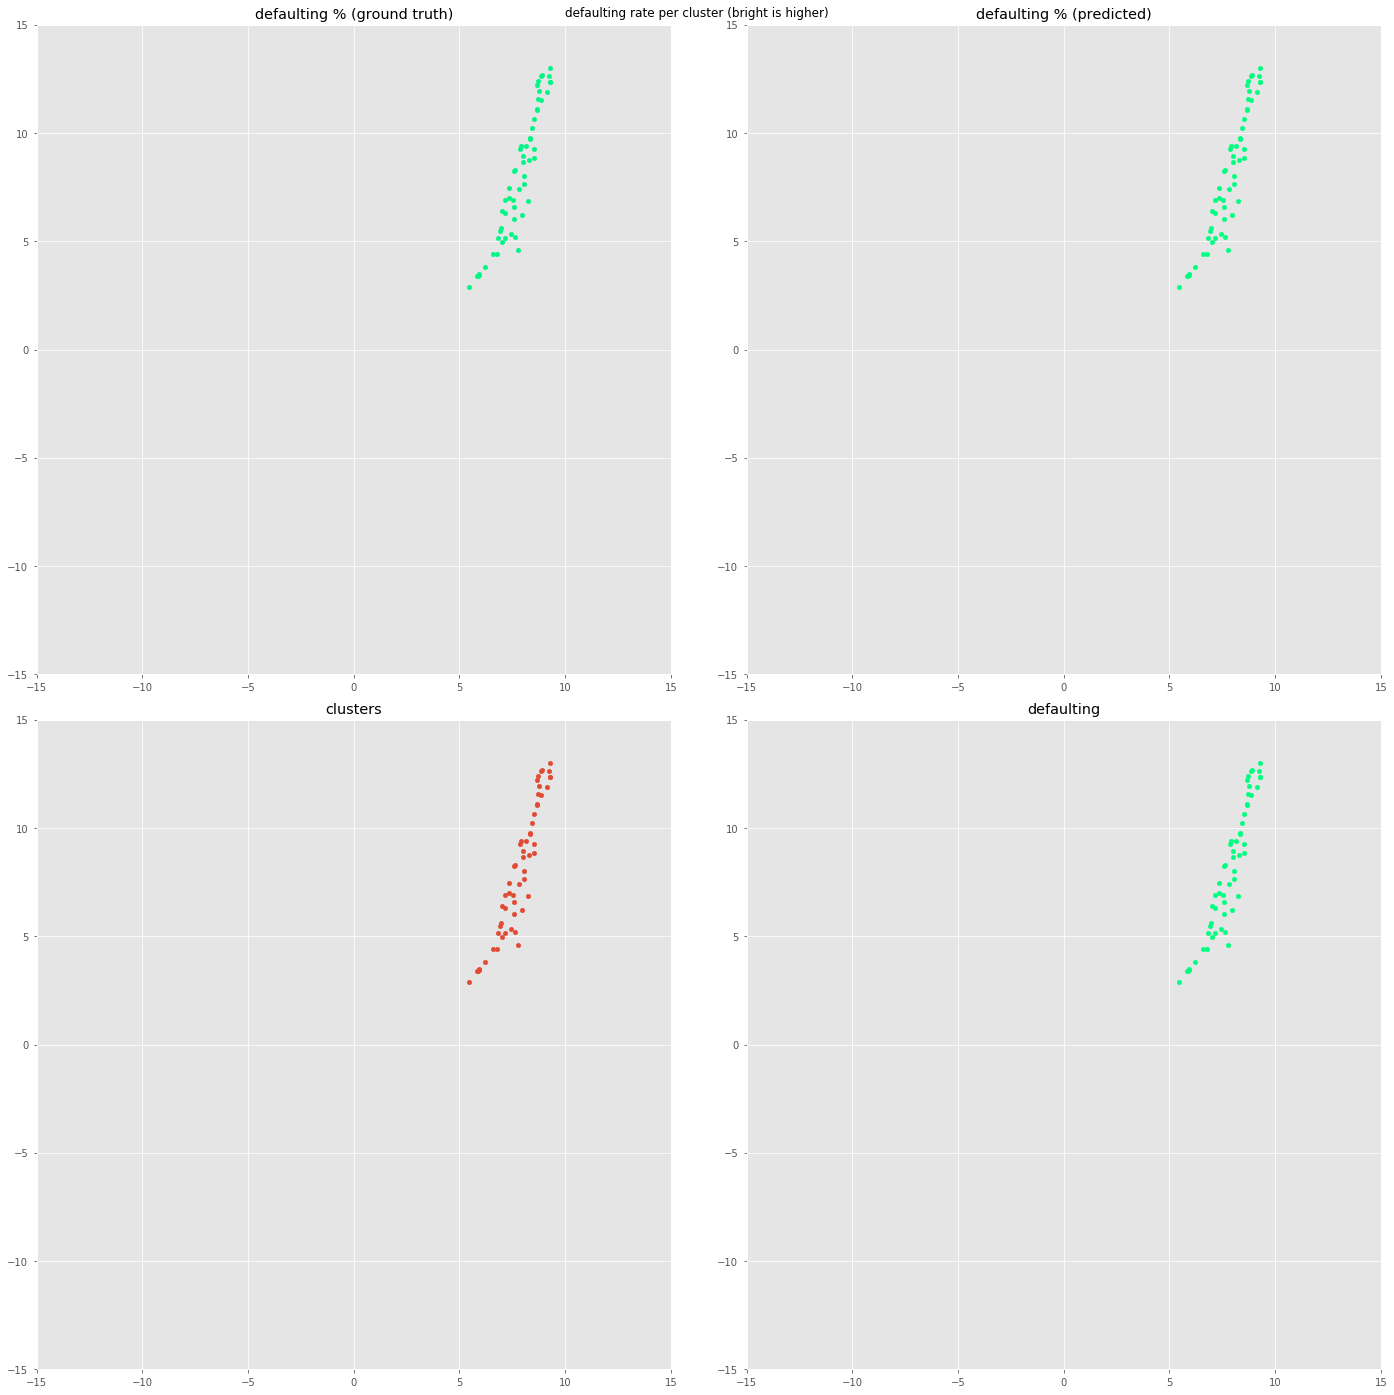

In [46]:
# prepare figure
fig,ax = plt.subplots(2,2)
fig.set_size_inches(20,20)

cmap = plt.cm.winter_r
color_true = cl_df['rate_truth'].apply(cmap)
color_pred = cl_df['rate_pred'].apply(cmap)

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlim([-15, 15])
        ax[i,j].set_ylim([-15, 15])

for i in range(len(clusters)):
    d = samples[clusters[i],:]
    
    ax[0,0].scatter(d[:,0], d[:,1], s=20, color=color_true[i])
    ax[0,1].scatter(d[:,0], d[:,1], s=20, color=color_pred[i])

    ax[1,0].scatter(d[:,0], d[:,1], s=20)
    if i in clusters_topsel.index:
        ax[1,1].scatter(d[:,0], d[:,1], s=20, color=color_pred[i])

fig.suptitle("defaulting rate per cluster (bright is higher)")

ax[0,0].set_title("defaulting % (ground truth)")
ax[0,1].set_title("defaulting % (predicted)")

ax[1,0].set_title('clusters')
ax[1,1].set_title('defaulting')

plt.tight_layout(pad=3, w_pad=4, h_pad=1.0)
plt.show()

#### Peeking on the brain :  TDA analysis on TSNE lens

In [37]:
import os
os.chdir('/home/tapas/deepcredit/')
os.listdir('.')

['Default_research.ipynb',
 'README.md',
 '.gitignore',
 'data',
 '.ipynb_checkpoints',
 '__pycache__',
 'default-prediction.ipynb',
 'km.py',
 'd3.min.js',
 'requirements.txt',
 'output.html',
 '.git']

In [38]:
import importlib

In [39]:
# Import the class
import km

# Initialize
mapper = km.KeplerMapper(verbose=1)

# Fit to and transform the data
projected_data = mapper.fit_transform(samples, projection=[0,1]) #list(range(activations.shape[1])))

projected_data.shape

Projecting data using: [0, 1]
Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))


(82, 2)

In [40]:
# Create dictionary called 'complex' with nodes, edges and meta-information
complex = mapper.map(projected_data, activations, nr_cubes=20,clusterer=tda.cluster.DBSCAN(eps=0.01, min_samples=10), overlap_perc=0.5)

NameError: name 'tda' is not defined

In [ ]:
# Visualize it
mapper.visualize(complex, path_html="output.html", show_title=False, 
                 show_meta=False, bg_color_css="#FFF", graph_gravity=0.4)

from IPython.display import IFrame
IFrame('output.html', width='100%', height=700)